In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import turbofats

## Create a lightcurve

In [2]:
n_samples = 40
n_days = 100
n_components = 7
period = 7.4
std = 0.5
time = np.random.rand(n_samples) * n_days
time.sort()
time = time.reshape(-1, 1)
cosine_components = np.random.randn(1, n_components) * np.exp(-np.linspace(0, 4, n_components))
sine_components = np.random.randn(1, n_components) * np.exp(-np.linspace(0, 4, n_components))
bias = np.random.randn(1) * 5

time_arg = 2*np.pi*time/(period/np.arange(1, n_components+1).reshape(1, n_components))
magnitude = np.sum(cosine_components * np.cos(time_arg) + sine_components * np.sin(time_arg), axis=1) + bias

error = np.ones(n_samples)*std + np.random.rand(n_samples)*std*3

magnitude += error

(40, 1) (40,)


<ErrorbarContainer object of 3 artists>

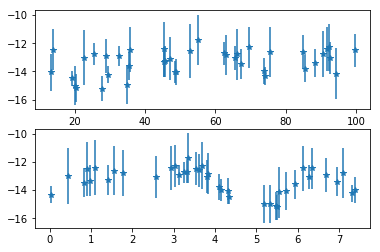

In [3]:
print(time.shape, magnitude.shape)
plt.subplot(2, 1, 1)
plt.errorbar(time, magnitude, yerr=error, fmt='*')
plt.subplot(2, 1, 2)
plt.errorbar(time % period, magnitude, yerr=error, fmt='*')

In [4]:
feature_space = turbofats.NewFeatureSpace(feature_list=['PeriodLS_v2', 'Period_fit_v2', 'Harmonics'])

[ 9.060267   9.072375   9.072394   9.09189    9.133331   9.188656
  9.223631   9.28091    9.319971   9.350154   9.365844   9.3916445
  9.396765   9.438461   9.491005   9.492975   9.503294   9.586125
  9.606044   9.640482   9.657579   9.668729   9.695982   9.715331
  9.74061    9.7429695  9.756144   9.758529   9.767673   9.805067
  9.854806   9.888103   9.889038   9.900953   9.92519    9.988682
  9.989776   9.996125  10.091356  10.118684  10.122951  10.181804
 10.270289  10.300608  10.32912   10.346446  10.3558035 10.3788185
 10.3879    10.396926  10.399192  10.432555  10.456505  10.540945
 10.741738  10.751128  10.974197  10.990708  11.062629  11.067848
 11.073316  11.184135  11.278     11.334426  11.504793  11.637545
 12.050495  12.628398  12.775152  13.091623  13.172349  13.357381
 13.398573  13.6624    14.0049515 14.214692  14.264996  14.357451
 14.660521  14.694979  14.932308  15.737201  15.79392   15.808742
 16.028828  16.338755  16.382946  16.721611  16.79275   17.055584
 17.2599

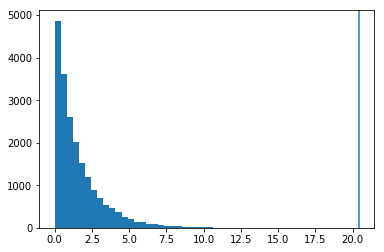

In [5]:
detections_data = np.stack(
    [
        time.flatten(),
        magnitude.flatten(),
        error
    ],
    axis=-1
)
detections = pd.DataFrame(
    data=detections_data,
    columns=['mjd', 'magpsf_corr', 'sigmapsf_corr'],
    index=['asdf'] * len(detections_data)
)
feature_values = feature_space.calculate_features(detections)

In [6]:
print(cosine_components)
print(sine_components)
print(np.sqrt(cosine_components**2 + sine_components**2))
feature_values

[[-0.02445945  0.35455593 -0.52157299 -0.16845876  0.06778107  0.02097671
  -0.00546683]]
[[ 0.44398781 -0.48612234 -0.13376353 -0.04047947  0.16188136 -0.11202063
  -0.0344589 ]]
[[0.44466104 0.601685   0.53845248 0.17325398 0.17549886 0.11396773
  0.03488985]]


,PeriodLS_v2,Period_fit_v2,Harmonics_mag_1,Harmonics_mag_2,Harmonics_mag_3,Harmonics_mag_4,Harmonics_mag_5,Harmonics_mag_6,Harmonics_mag_7,Harmonics_phase_2,Harmonics_phase_3,Harmonics_phase_4,Harmonics_phase_5,Harmonics_phase_6,Harmonics_phase_7,Harmonics_mse
oid,,,,,,,,,,,,,,,,
asdf,0.072123,0.006581,0.626274,0.500293,0.119416,0.050927,0.332236,0.41472,0.19265,2.794815,0.394713,5.998939,1.144061,0.879005,3.32233,0.38673


In [7]:
reconstructed_period = feature_values['PeriodLS_v2'].values[0]
reconstructed_time_arg = 2*np.pi*time/(reconstructed_period/np.arange(1, n_components+1).reshape(1, n_components))
print(reconstructed_time_arg.shape)
reconstructed_harmonics_mag = np.array([feature_values['Harmonics_mag_%d' % i].values[0] for i in range(1, 8)])
reconstructed_harmonics_phase = np.array([0.0] + [feature_values['Harmonics_phase_%d' % i].values[0] for i in range(2, 8)])

reconstructed_mag = reconstructed_harmonics_mag.reshape(1, -1)*np.cos(reconstructed_time_arg - reconstructed_harmonics_phase.reshape(1, -1))
reconstructed_mag = np.real(np.sum(reconstructed_mag, axis=1) + np.mean(magnitude))

(40, 7)


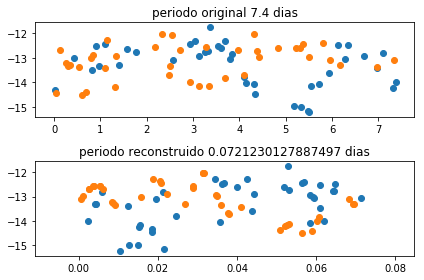

In [8]:
plt.subplot(2, 1, 1)
plt.scatter(time % period, magnitude)
plt.scatter((time - 3.0) % period, reconstructed_mag)
plt.title(f'periodo original {period} dias')
plt.subplot(2, 1, 2)
plt.scatter(time % reconstructed_period, magnitude)
plt.scatter((time-0.2) % reconstructed_period, reconstructed_mag)
plt.title(f'periodo reconstruido {reconstructed_period} dias')

plt.tight_layout()

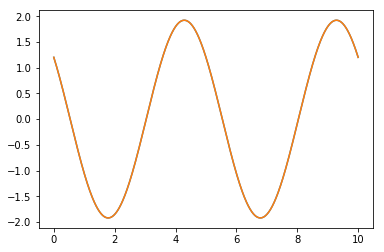

In [9]:
tt = np.linspace(0, 10, 1000)
a = 1.2
b = -1.5
f = 0.2
y = a*np.cos(2*np.pi*f*tt) + b*np.sin(2*np.pi*f*tt)
plt.plot(tt, y)
m = np.sqrt(a**2 + b**2)
phi = np.arctan2(b, a)
y2 = m*np.cos(2*np.pi*f*tt-phi)
plt.plot(tt, y2)